# Feature Matrix Preparation

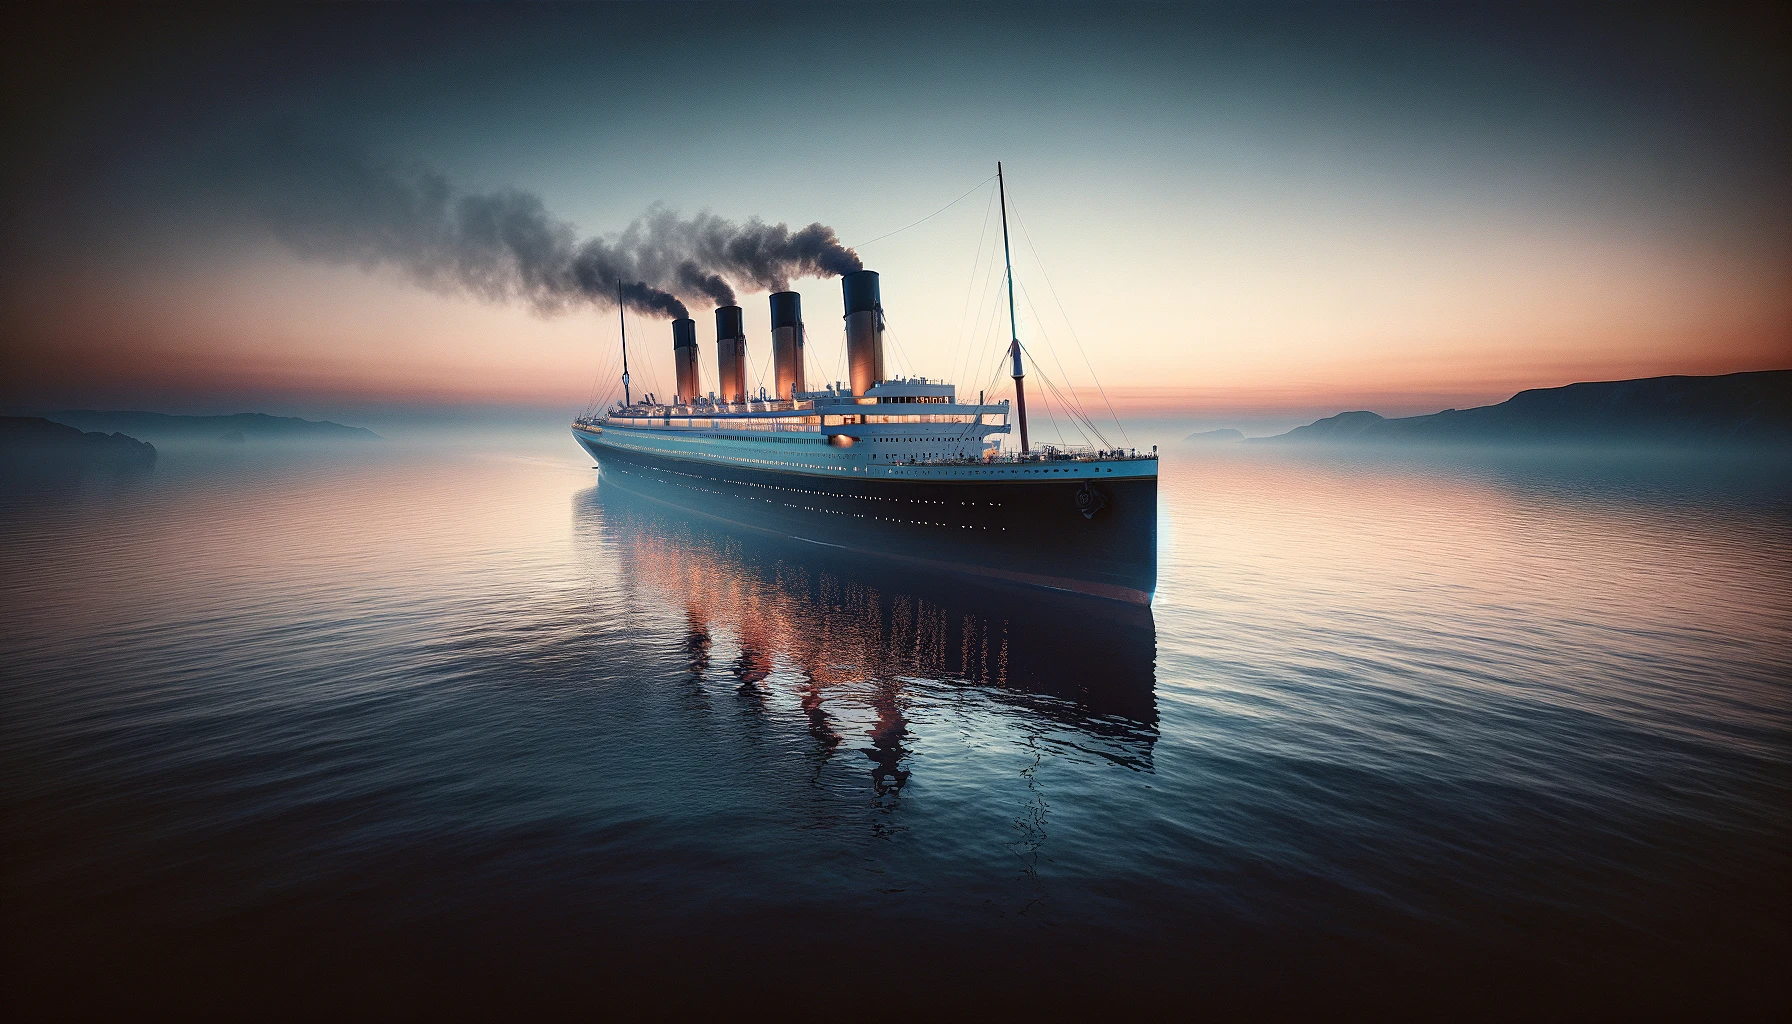

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from sklearn.model_selection import train_test_split

## Create a feature matrix and target column

In [7]:
data = pd.read_csv('datasets/strat_train.csv')
titanic_test = pd.read_csv('datasets/strat_test.csv')

train_data, dev_data = train_test_split(data,
                                                   test_size=0.2,
                                                   stratify=data['Pclass'],
                                                   random_state=18)

#titanic = train_data.drop(columns=['Survived'])
titanic_train = train_data.copy()
#targets = train_data['Survived']
#titanic_dev = dev_data.drop(columns=['Survived'])
titanic_dev = dev_data.copy()
#targets_dev = dev_data['Survived']

print(f"Train set has dimensions {titanic_train.shape}")
print(f"Dev set has dimensions {titanic_dev.shape} ")
print('\n------------------------------------------\n')
titanic_train.info()

Train set has dimensions (569, 12)
Dev set has dimensions (143, 12) 

------------------------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 644 to 55
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  569 non-null    int64  
 1   Survived     569 non-null    int64  
 2   Pclass       569 non-null    int64  
 3   Name         569 non-null    object 
 4   Sex          569 non-null    object 
 5   Age          454 non-null    float64
 6   SibSp        569 non-null    int64  
 7   Parch        569 non-null    int64  
 8   Ticket       569 non-null    object 
 9   Fare         569 non-null    float64
 10  Cabin        130 non-null    object 
 11  Embarked     567 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 57.8+ KB


Based on the current form of the feature matrix, we have to decide what to do with each column in the dataset.  
- **PassengerId**: drop column  
- **Pclass**: one-hot encoding  
- **Name**: drop column  
- **Sex**: one-hot encoding  
- **Age**: ???  
- **SibSp**: ???  
- **Parch**: ???  
- **Ticket**: ???  
- **Fare**: transform  
- **Cabin**: ??  
- **Embarked**: one-hot encoding  

In [8]:
columns = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']

for column in columns:
    print(column)
    print(titanic_train[column].unique())

Pclass
[3 1 2]
Sex
['male' 'female']
SibSp
[1 0 3 5 2 4 8]
Parch
[0 1 2 4 5 3 6]
Embarked
['S' 'C' 'Q' nan]


## Pipelines

In [9]:
# To set visibility of pipelines
from sklearn.impute import SimpleImputer
from sklearn import set_config
set_config(display="diagram")

### Missing values

First, we have to deal with missing values. Even though in the training dataset we do not have too many missing values, this might be different in the samples for predictions. That is why we have to find a strategy to deal with missing values in all columns.

In [12]:
no_missing = list(titanic_train.isna().sum())
dtype = titanic_train.dtypes.tolist()
missing_df = pd.DataFrame({'column':titanic_train.columns, 
                           '# missing':no_missing, 
                           'dtype':dtype}
                         ).sort_values(by='# missing', ascending=False)
print(missing_df)

         column  # missing    dtype
10        Cabin        439   object
5           Age        115  float64
11     Embarked          2   object
0   PassengerId          0    int64
1      Survived          0    int64
2        Pclass          0    int64
3          Name          0   object
4           Sex          0   object
6         SibSp          0    int64
7         Parch          0    int64
8        Ticket          0   object
9          Fare          0  float64


In [13]:
# Simple inputer fit
num_imputer = SimpleImputer(strategy='mean')
titanic_num = titanic_train.select_dtypes(include=[np.number])
num_imputer.fit(titanic_num)

SimpleImputer()

In [14]:
print(f"Imputer: {list(num_imputer.statistics_)}")
print(f"Calculated: {titanic_num.mean().to_list()}")

Imputer: [451.2952548330404, 0.37258347978910367, 2.3075571177504393, 30.359030837004404, 0.5342706502636204, 0.421792618629174, 32.65495659050966]
Calculated: [451.2952548330404, 0.37258347978910367, 2.3075571177504393, 30.359030837004404, 0.5342706502636204, 0.421792618629174, 32.65495659050966]


In [15]:
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(titanic_train) # learn parameters for the imputer
X_inp = imputer.transform(titanic_train)
titanic_inp = pd.DataFrame(X_inp, columns=titanic_train.columns, index=titanic_train.index)
titanic_inp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 644 to 55
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  569 non-null    object
 1   Survived     569 non-null    object
 2   Pclass       569 non-null    object
 3   Name         569 non-null    object
 4   Sex          569 non-null    object
 5   Age          569 non-null    object
 6   SibSp        569 non-null    object
 7   Parch        569 non-null    object
 8   Ticket       569 non-null    object
 9   Fare         569 non-null    object
 10  Cabin        569 non-null    object
 11  Embarked     569 non-null    object
dtypes: object(12)
memory usage: 57.8+ KB


In [16]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer, KBinsDiscretizer, OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder

In [17]:
def column_sum(X):
    return X[:, [0]] + X[:, [1]]

def sum_name(function_transformer, feature_names_in):
    return ["sum"]  # feature names out

In [18]:
log_pipeline = make_pipeline(
    KNNImputer(),
    FunctionTransformer(np.log1p, feature_names_out="one-to-one"),
    MinMaxScaler(feature_range=(0, 1)))

In [19]:
one_hot_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder())

In [20]:
ordinal_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=[['S', 'C', 'Q']]))

In [21]:
kmeans_pipeline = make_pipeline(
    KNNImputer(),
    MinMaxScaler(feature_range=(0, 1)))

In [22]:
default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    MinMaxScaler(feature_range=(0, 1)))

In [23]:
sum_pipeline = make_pipeline(
    SimpleImputer(strategy="mean"),
    FunctionTransformer(column_sum, feature_names_out=sum_name),
    MinMaxScaler(feature_range=(0, 1)))

In [24]:
preprocessing = ColumnTransformer([
    ("Relatives", sum_pipeline, ['Parch', 'SibSp']),
    ("Log", log_pipeline, ["Fare"]),
    ("One_hot", one_hot_pipeline, ["Sex"]),
    ("Ordinal", ordinal_pipeline, ["Embarked"]),
    ("Numeric", default_num_pipeline, ['SibSp', 'Parch']),
    ("KNN", kmeans_pipeline, ['Age']),
    ("Pass", "passthrough", ['Pclass', 'Survived'])
],
remainder="drop"
)

preprocessing

ColumnTransformer(transformers=[('Relatives',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out=<function sum_name at 0x15199dd80>,
                                                                      func=<function column_sum at 0x15199d870>)),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['Parch', 'SibSp']),
                                ('Log',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('functiontransfo...
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['S',
                                                                              'C',
                                                                              'Q']]))]),
                                 ['Embarked']),
                                ('Numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['SibSp', 'Parch']),
                                ('KNN',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['Age']),
                                ('Pass', 'passthrough',
                                 ['Pclass', 'Survived'])])

In [25]:
X_train = preprocessing.fit_transform(titanic_train)
titanic_train = pd.DataFrame(X_train, columns=preprocessing.get_feature_names_out(), index=titanic_train.index)

titanic_train.to_csv('input-data/titanic_train.csv')

In [26]:
X_dev = preprocessing.fit_transform(titanic_dev)
titanic_dev = pd.DataFrame(X_dev, columns=preprocessing.get_feature_names_out(), index=titanic_dev.index)

titanic_dev.to_csv('input-data/titanic_dev.csv')

In [27]:
X_test = preprocessing.fit_transform(titanic_test)
titanic_test = pd.DataFrame(X_test, columns=preprocessing.get_feature_names_out(), index=titanic_test.index)

titanic_test.to_csv('input-data/titanic_test.csv')